Input Variables


Variable,Value
Loan Amount,"AED 800,000.00"
Initial Interest Rate,4.50%
Initial Period,3 years
Later Interest Rate,8.00%
Total Loan Term,25 years
Regular Early Repayment,"AED 10,000.00"
Regular Early Repayment Interval,12 months
First Regular Early Repayment Date,2084-07-01
Property Price,"AED 1,000,000.00"
Property Size,850 sqft


Mortgage Insights


Metric,Value
Property Price,"AED 1,000,000.00"
Loan Amount,"AED 800,000.00"
Down Payment,"AED 200,000.00"
Initial Fees (excluding down payment),"AED 84,470.00"
Total Initial Costs (including down payment),"AED 284,470.00"
Initial Interest Rate,4.50%
Fixed Rate Period,3 years
Reversion (Later) Interest Rate,8.00%
Loan Tenure,25 years
Loan to Value (LTV),80.00%


Mortgage Payment Plan


,Date,Principal,Interest,Early Repayment,ER Fee,Insurance,Maint,Payments Sum,Mortgage Balance,Investments,Net Cash Flow
1,2084-01-01,"1,446.66","3,000.00",0.00,0.00,432.73,"15,300.00","20,179.39","798,553.34","52,139.61","-9,068.39"
2,2084-02-01,"1,452.08","2,994.58",0.00,0.00,432.13,0.00,"4,878.79","797,101.26","58,567.35","6,427.74"
3,2084-03-01,"1,457.53","2,989.13",0.00,0.00,431.52,0.00,"4,878.18","795,643.73","65,019.80","6,452.45"
4,2084-04-01,"1,463.00","2,983.66",0.00,0.00,430.91,0.00,"4,877.57","794,180.73","71,497.05","6,477.26"
5,2084-05-01,"1,468.48","2,978.18",0.00,0.00,430.30,0.00,"4,876.96","792,712.25","77,999.21","6,502.16"
6,2084-06-01,"1,473.99","2,972.67",0.00,0.00,429.68,0.00,"4,876.34","791,238.26","84,526.37","6,527.15"
7,2084-07-01,"1,479.52","2,967.14","10,000.00",0.00,424.90,0.00,"14,871.56","779,758.74","81,082.78","-3,443.59"
8,2084-08-01,"1,522.56","2,924.10",0.00,0.00,424.27,0.00,"4,870.92","778,236.18","87,626.92","6,544.14"
9,2084-09-01,"1,528.27","2,918.39",0.00,0.00,423.63,0.00,"4,870.29","776,707.90","94,196.23","6,569.31"
10,2084-10-01,"1,534.01","2,912.65",0.00,0.00,422.99,0.00,"4,869.65","775,173.90","100,790.81","6,594.59"


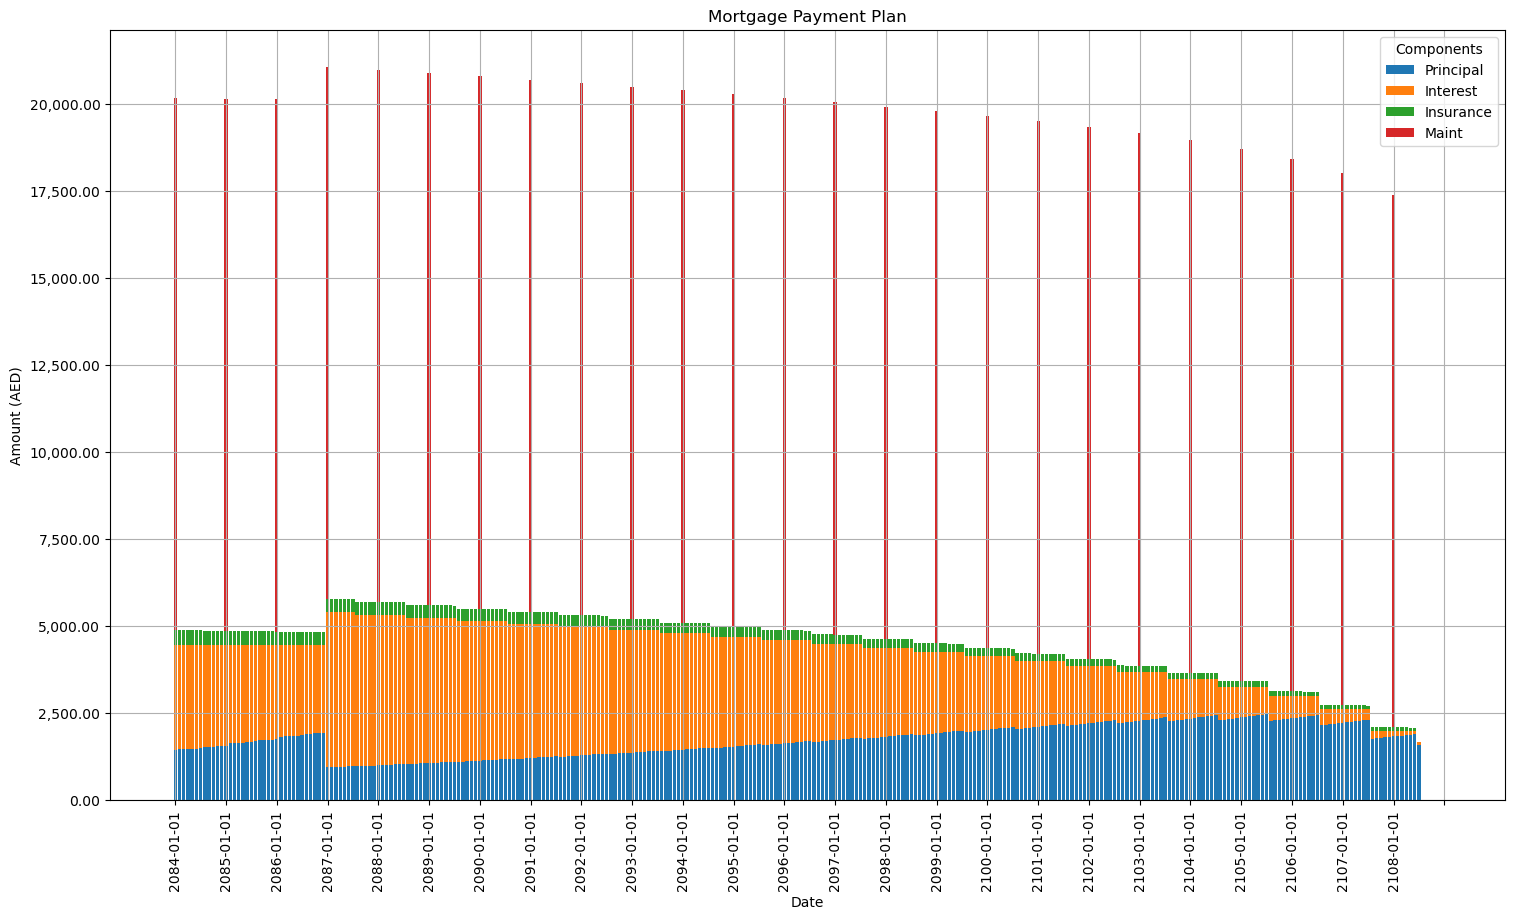

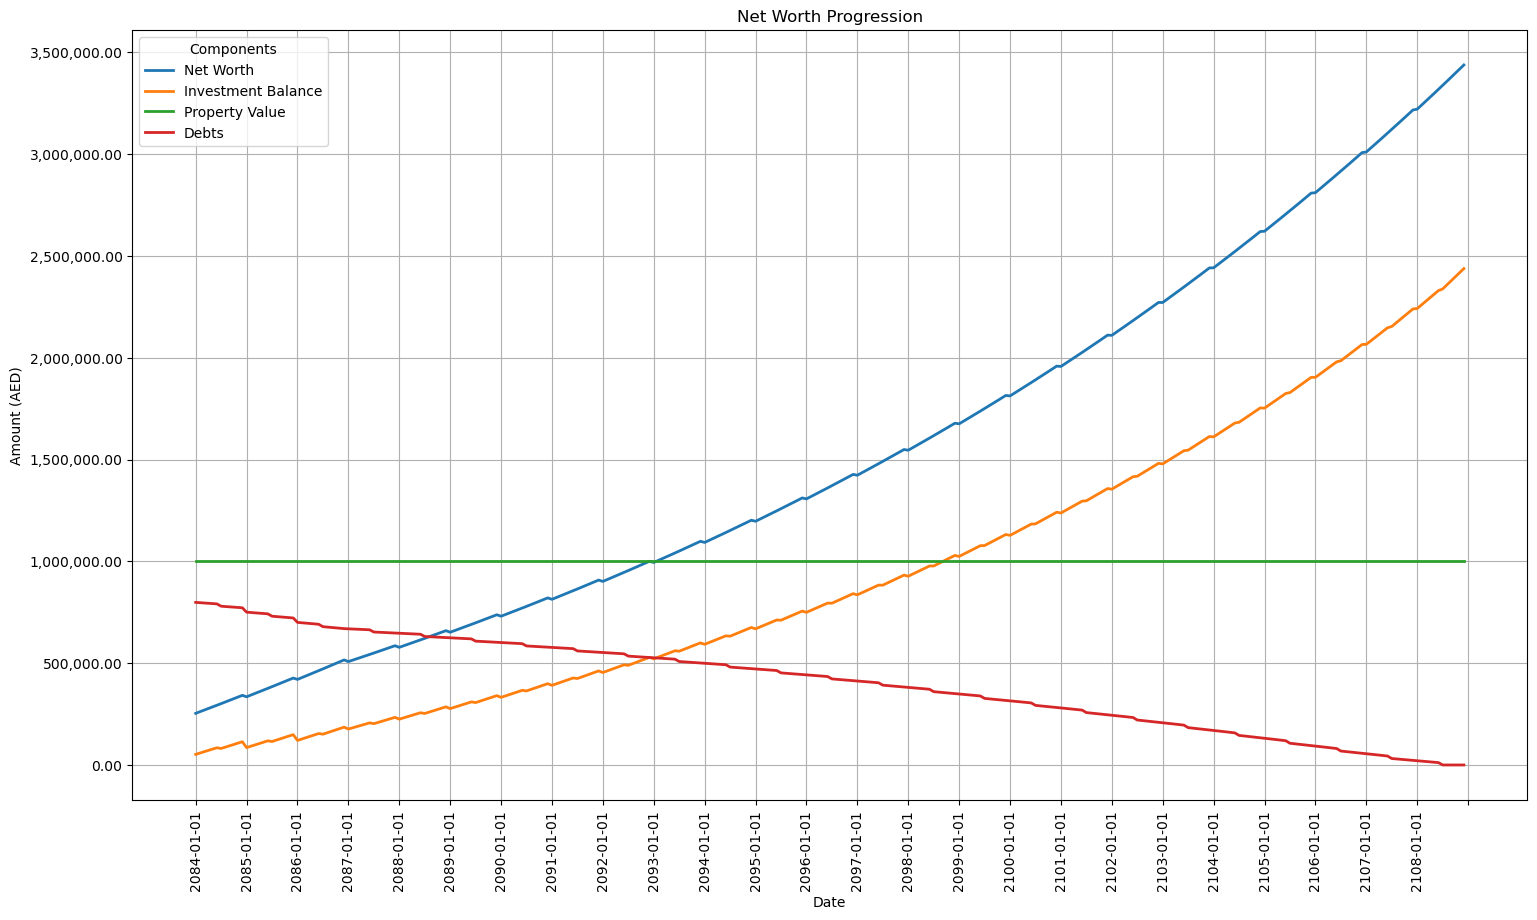

Investment Balance Progression


,Date,Balance,Interest,Rent,EJARI Fee,Top Up,Move-in Costs
1,2084-02-01,"299,392.63","1,270.30","55,250.00",416.67,"11,111.00","3,000.00"
2,2084-03-01,"311,187.18","1,100.21",0.00,416.67,"11,111.00",0.00
3,2084-04-01,"323,025.07","1,143.55",0.00,416.67,"11,111.00",0.00
4,2084-05-01,"334,906.45","1,187.06",0.00,416.67,"11,111.00",0.00
5,2084-06-01,"346,831.50","1,230.72",0.00,416.67,"11,111.00",0.00
6,2084-07-01,"358,800.38","1,274.54",0.00,416.67,"11,111.00",0.00
7,2084-08-01,"320,813.23","1,318.52","50,000.00",416.67,"11,111.00",0.00
8,2084-09-01,"332,686.49","1,178.93",0.00,416.67,"11,111.00",0.00
9,2084-10-01,"344,603.39","1,222.56",0.00,416.67,"11,111.00",0.00
10,2084-11-01,"356,564.07","1,266.35",0.00,416.67,"11,111.00",0.00



Total Earned Interest: AED 2,146,707.82
Total Rental Costs: AED 2,699,250.00
Total Move-In Costs: AED 1,166,979.82


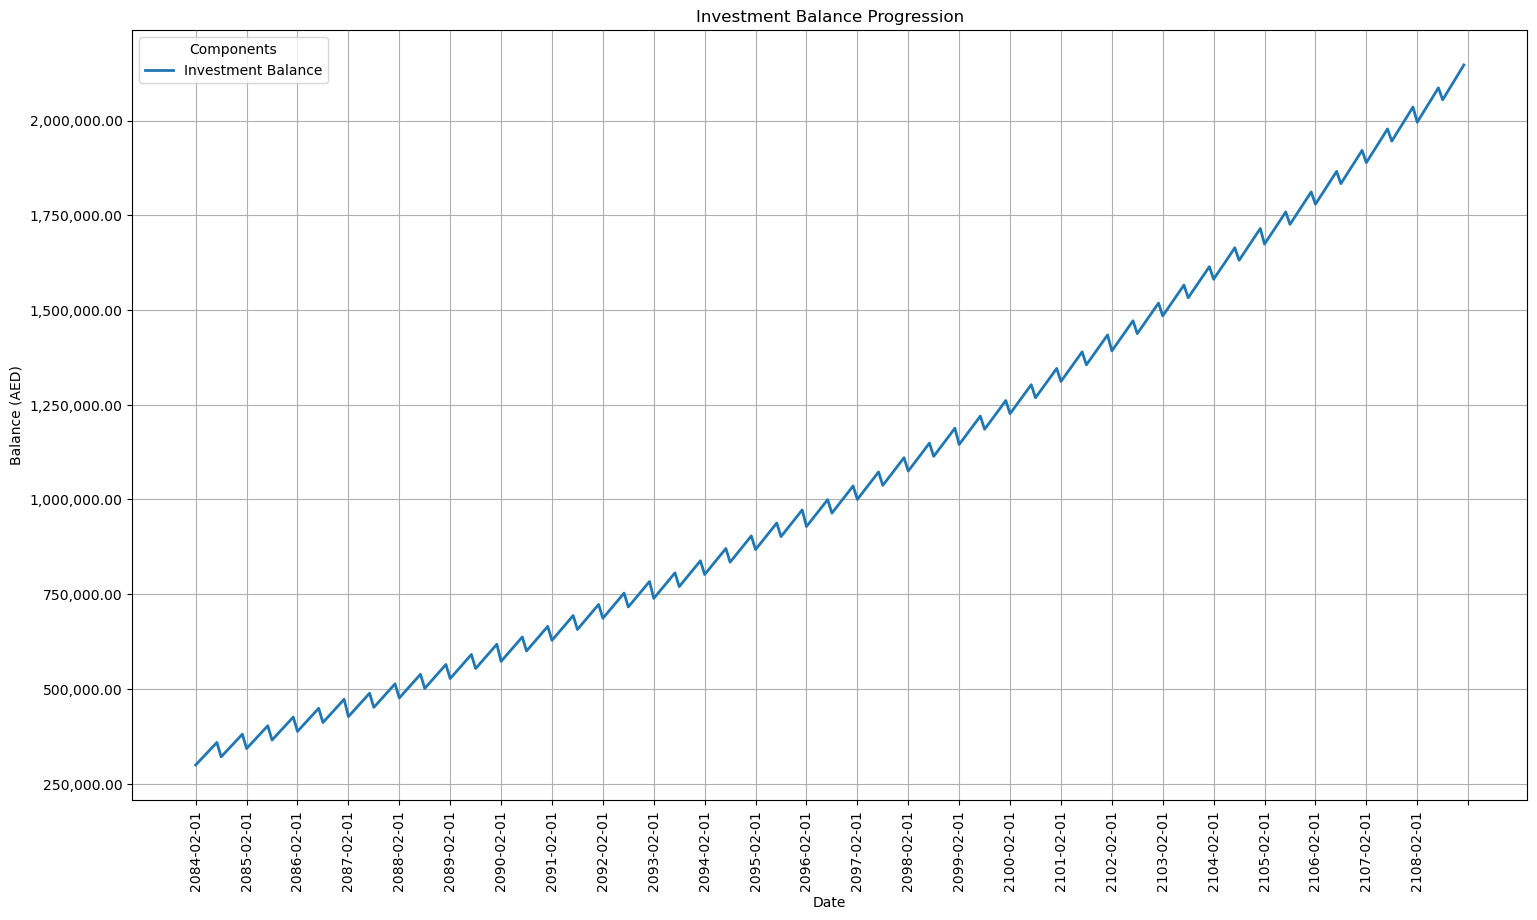

Net Worth Comparison


,Date,Net Worth (Mortgage),Net Worth (Rent & Invest)
1,2084-01-01,"253,586.27",nan
2,2084-02-01,"261,466.09","299,392.63"
3,2084-03-01,"269,376.07","311,187.18"
4,2084-04-01,"277,316.32","323,025.07"
5,2084-05-01,"285,286.96","334,906.45"
6,2084-06-01,"293,288.11","346,831.50"
7,2084-07-01,"301,324.04","358,800.38"
8,2084-08-01,"309,390.74","320,813.23"
9,2084-09-01,"317,488.32","332,686.49"
10,2084-10-01,"325,616.92","344,603.39"


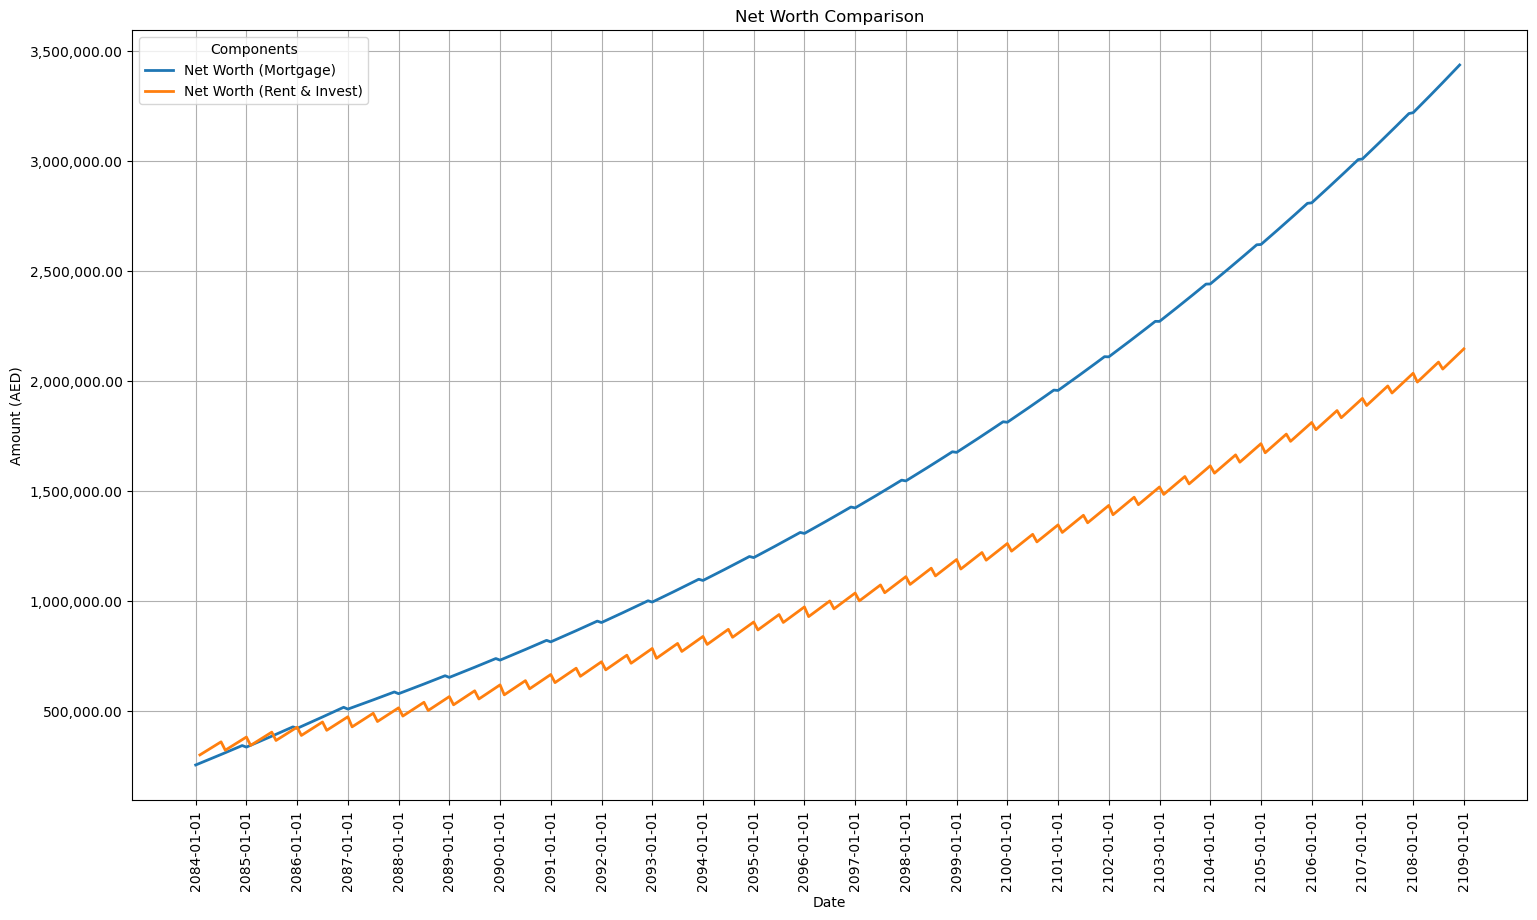

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from datetime import datetime, timedelta

"""
Legal Disclaimer:
This script is provided for informational and educational purposes only.
It is not intended as financial advice and should not be construed as such.
Users should seek professional advice from a qualified financial advisor before making any financial decisions.
The author of this script does not guarantee the accuracy or completeness of any information provided and is not responsible for any errors or omissions or any losses arising from its use.
"""

# EXAMPLE VALUES

# Mortgage input variables
start_date = '2084-01-01'  # Start date for payments
first_regular_early_repayment_date = '2084-07-01'  # First regular early repayment date

principal = 800000  # Loan amount in AED
property_price = 1000000  # Property price in AED

initial_savings = 345678  # Initial savings in AED
monthly_salary = 23456  # Monthly salary in AED
monthly_expenses = 12345  # Monthly expenses in AED (excluding rent)

property_size = 850  # Property size in square feet
maintenance_fees_rate = 18  # AED per square foot per year
maintenance_fees_interval = 12  # Maintenance fees paid every year

initial_rate = 4.5  # Initial interest rate in percent
initial_years = 3  # Initial period in years
later_rate = 8  # Later interest rate in percent
total_years = 25  # Total loan term in years

allow_exceed_early_repayment_limit = False  # Allow exceeding early repayment limit with fees
max_early_repayment_percent = 20  # Maximum allowed annual early repayment percentage
regular_early_repayment = 10000  # Regular early repayment amount in AED
regular_early_repayment_interval = 12  # Interval of regular early repayment in months
arbitrary_early_repayments = [
    {'date': '2085-01-01', 'amount': 20000},
    {'date': '2086-01-01', 'amount': 20000}
]

property_value_factor = 1.0  # Property value remains the same
annual_investment_rate = 4.5  # Annual investment interest rate in percent
valuation_fee = 3150  # Property valuation fee from the bank
conveyance_fee = 5250  # Conveyance fee
bank_mortgage_opening_fee_rate = 1  # Bank mortgage opening fee rate (1%)
life_insurance_rate = 0.5  # Annual life insurance rate in percent
property_insurance_rate = 0.12  # Annual property insurance rate in percent
insurance_payment_interval = 1  # Monthly insurance payment interval

# Rent & Invest input variables
annual_rent = 100000  # Annual rent in AED
rent_cheques = 2  # Number of rent cheques per year
years = total_years  # Investment period in years
change_apartment_interval = 3  # Change apartment every 3 years
initial_amount = initial_savings  # Initial amount equal to initial savings
move_in_costs = 3000  # Move-in costs for each new apartment


class MortgageCalculator:
    def __init__(self, principal, initial_rate, initial_years, later_rate, total_years, property_price, property_size, maintenance_fees_rate, maintenance_fees_interval, life_insurance_rate=0.216, property_insurance_rate=0.12, insurance_payment_interval=1, annual_investment_rate=4.5, regular_early_repayment=0, regular_early_repayment_interval=0, property_value_factor=1.0, valuation_fee=1750, conveyance_fee=5250, bank_mortgage_opening_fee_rate=1, max_early_repayment_percent=10, start_date='2084-01-01', first_regular_early_repayment_date='2085-01-01', allow_exceed_early_repayment_limit=False, arbitrary_early_repayments=[]):
        self.principal = principal
        self.initial_rate = initial_rate / 100 / 12  # Convert annual rate to monthly
        self.initial_years = initial_years
        self.later_rate = later_rate / 100 / 12  # Convert annual rate to monthly
        self.total_years = total_years
        self.property_price = property_price
        self.property_size = property_size
        self.maintenance_fees_rate = maintenance_fees_rate
        self.maintenance_fees_interval = maintenance_fees_interval
        self.regular_early_repayment = regular_early_repayment
        self.regular_early_repayment_interval = regular_early_repayment_interval
        self.total_months = total_years * 12
        self.life_insurance_rate = life_insurance_rate / 100  # Convert annual rate to fraction
        self.property_insurance_rate = property_insurance_rate / 100  # Convert annual rate to fraction
        self.insurance_payment_interval = insurance_payment_interval
        self.annual_investment_rate = annual_investment_rate / 100 / 12  # Monthly investment rate
        self.valuation_fee = valuation_fee
        self.conveyance_fee = conveyance_fee
        self.bank_mortgage_opening_fee_rate = bank_mortgage_opening_fee_rate / 100  # Convert to fraction
        self.property_value_factor = property_value_factor  # Initialize the property value factor
        self.maintenance_fees = property_size * maintenance_fees_rate  # Total maintenance fees per year
        self.max_early_repayment_percent = max_early_repayment_percent / 100  # Convert to fraction
        self.start_date = datetime.strptime(start_date, '%Y-%m-%d')
        self.first_regular_early_repayment_date = datetime.strptime(first_regular_early_repayment_date, '%Y-%m-%d')
        self.allow_exceed_early_repayment_limit = allow_exceed_early_repayment_limit
        self.arbitrary_early_repayments = [rep for rep in arbitrary_early_repayments if datetime.strptime(rep['date'], '%Y-%m-%d') >= self.start_date]
        self.early_repayment_fees = 0

        # Initial invested value calculation
        down_payment = self.property_price - self.principal
        initial_fees = self.calculate_initial_costs(self.property_price)
        total_initial_costs = down_payment + initial_fees

        if initial_savings < total_initial_costs:
            raise ValueError("Initial savings are less than the total initial costs including down payment.")


    def calculate_payment(self, rate, n_months, principal):
        """ Calculate the monthly mortgage payment using the formula for an annuity. """
        if principal <= 0:
            return 0
        return principal * (rate * (1 + rate)**n_months) / ((1 + rate)**n_months - 1)

    def calculate_remaining_term(self, rate, monthly_payment, principal):
        """ Calculate the remaining term in months given the rate, monthly payment, and remaining principal. """
        return np.log(monthly_payment / (monthly_payment - rate * principal)) / np.log(1 + rate)

    def get_payment_date(self, start_date, month):
        """ Calculate the payment date on the same day of the month, or the last day if necessary. """
        year = start_date.year + (start_date.month + month - 1) // 12
        month = (start_date.month + month - 1) % 12 + 1
        day = min(start_date.day, [31, 29 if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0) else 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31][month - 1])
        return datetime(year, month, day)

    def calculate_early_repayment(self, early_repayment_amt, remaining_principal, investment_balance, annual_early_repayments):
        """ Calculate the total applicable early repayment amount and fees without modifying balances. """
        early_repayment_fee = 0
        max_allowed_annual_repayment = self.principal * self.max_early_repayment_percent
        remaining_annual_repayment_limit = max_allowed_annual_repayment - annual_early_repayments

        if early_repayment_amt > remaining_annual_repayment_limit:
            if self.allow_exceed_early_repayment_limit:
                early_repayment_fee = min(0.01 * remaining_principal, 10000)
                if early_repayment_amt + early_repayment_fee > investment_balance:
                    early_repayment_amt = investment_balance - early_repayment_fee
                self.early_repayment_fees += early_repayment_fee
            else:
                early_repayment_amt = remaining_annual_repayment_limit

        if early_repayment_amt > remaining_principal:
            early_repayment_amt = remaining_principal

        actual_repayment_amt = early_repayment_amt

        if early_repayment_amt > investment_balance:
            actual_repayment_amt = investment_balance

        return actual_repayment_amt, early_repayment_fee, annual_early_repayments + actual_repayment_amt

    def generate_payment_plan(self, monthly_salary, monthly_expenses, initial_savings):
        payment_plan = []
        remaining_principal = self.principal
        total_interest_paid = 0
        total_insurance_costs = 0
        total_maintenance_costs = 0
        annual_early_repayments = 0
        total_early_repayment_fees = 0
        highlight_row = None

        # Calculate EMI for the initial period based on total loan duration
        initial_months = self.initial_years * 12
        total_months = self.total_years * 12
        total_emi = self.calculate_payment(self.initial_rate, total_months, self.principal)

        # Initial invested value calculation
        down_payment = self.property_price - self.principal
        initial_fees = self.calculate_initial_costs(self.property_price)
        initial_invested_value = initial_savings - down_payment - initial_fees

        investment_balance = initial_invested_value
        net_worth_progression = []

        # Prepare regular and arbitrary early repayment dates
        next_regular_early_repayment_date = self.first_regular_early_repayment_date
        regular_early_repayment_dates = []
        arbitrary_early_repayment_dates = sorted(self.arbitrary_early_repayments, key=lambda x: x['date'])

        # Calculate all regular early repayment dates
        while next_regular_early_repayment_date <= self.get_payment_date(self.start_date, total_months - 1):
            regular_early_repayment_dates.append(next_regular_early_repayment_date)
            next_regular_early_repayment_date = self.get_payment_date(next_regular_early_repayment_date, self.regular_early_repayment_interval)

        # Merge regular and arbitrary early repayment dates
        all_early_repayment_dates = []
        i, j = 0, 0
        while i < len(regular_early_repayment_dates) and j < len(arbitrary_early_repayment_dates):
            if regular_early_repayment_dates[i] <= datetime.strptime(arbitrary_early_repayment_dates[j]['date'], '%Y-%m-%d'):
                all_early_repayment_dates.append({'date': regular_early_repayment_dates[i], 'amount': self.regular_early_repayment, 'type': 'regular'})
                i += 1
            else:
                all_early_repayment_dates.append({'date': datetime.strptime(arbitrary_early_repayment_dates[j]['date'], '%Y-%m-%d'), 'amount': arbitrary_early_repayment_dates[j]['amount'], 'type': 'arbitrary'})
                j += 1
        while i < len(regular_early_repayment_dates):
            all_early_repayment_dates.append({'date': regular_early_repayment_dates[i], 'amount': self.regular_early_repayment, 'type': 'regular'})
            i += 1
        while j < len(arbitrary_early_repayment_dates):
            all_early_repayment_dates.append({'date': datetime.strptime(arbitrary_early_repayment_dates[j]['date'], '%Y-%m-%d'), 'amount': arbitrary_early_repayment_dates[j]['amount'], 'type': 'arbitrary'})
            j += 1

        early_repayment_index = 0

        for month in range(total_months):
            payment_date = self.get_payment_date(self.start_date, month)
            is_early_repayment_month = (early_repayment_index < len(all_early_repayment_dates) and payment_date >= all_early_repayment_dates[early_repayment_index]['date'])

            if month < initial_months:
                rate = self.initial_rate
            else:
                rate = self.later_rate
                # Recalculate EMI for the later period based on remaining principal and remaining loan duration
                remaining_months = total_months - month
                total_emi = self.calculate_payment(rate, remaining_months, remaining_principal)

            interest_payment = remaining_principal * rate
            principal_payment = total_emi - interest_payment
            total_early_repayment_amt = 0
            early_repayment_fee = 0

            # Calculate total early repayment amount for the month
            while is_early_repayment_month:
                early_repayment_amt, early_repayment_fee, annual_early_repayments = self.calculate_early_repayment(all_early_repayment_dates[early_repayment_index]['amount'], remaining_principal, investment_balance, annual_early_repayments)
                total_early_repayment_amt += early_repayment_amt
                total_early_repayment_fees += early_repayment_fee
                early_repayment_index += 1
                if early_repayment_index >= len(all_early_repayment_dates):
                    break
                is_early_repayment_month = (early_repayment_index < len(all_early_repayment_dates) and payment_date >= all_early_repayment_dates[early_repayment_index]['date'])

            # Apply the total early repayment amount once
            remaining_principal -= total_early_repayment_amt

            # Ensure the principal payment does not go negative
            if remaining_principal == 0:
                principal_payment = 0

            # Ensure the final payment does not go negative
            if remaining_principal - principal_payment < 0:
                principal_payment = remaining_principal
                total_emi = principal_payment + interest_payment

            remaining_principal -= principal_payment
            total_interest_paid += interest_payment

            # Only pay insurance if the principal is not fully paid off
            if remaining_principal > 0 and month % self.insurance_payment_interval == 0:
                life_insurance_cost = remaining_principal * (self.life_insurance_rate / 12)
                property_insurance_cost = self.property_price * (self.property_insurance_rate / 12)
            else:
                life_insurance_cost = 0
                property_insurance_cost = 0

            insurance_cost = life_insurance_cost + property_insurance_cost
            total_insurance_costs += insurance_cost
            maintenance_cost = self.maintenance_fees if month % self.maintenance_fees_interval == 0 else 0
            total_maintenance_costs += maintenance_cost
            total_monthly_payment = principal_payment + interest_payment + total_early_repayment_amt + early_repayment_fee + insurance_cost + maintenance_cost

            # Calculate net cash flow and update investment balance
            if month > 0:  # Apply investment interest from the second month
                investment_interest = investment_balance * self.annual_investment_rate
            else:
                investment_interest = 0

            net_cash_flow = monthly_salary - monthly_expenses - total_monthly_payment + investment_interest
            investment_balance += net_cash_flow

            # Calculate net worth
            property_value = self.property_price * self.property_value_factor
            net_worth = property_value - remaining_principal + investment_balance
            net_worth_progression.append({
                'Date': payment_date.strftime('%Y-%m-%d'),
                'Net Worth': net_worth,
                'Property Value': property_value,
                'Investment Balance': investment_balance,
                'Remaining Principal': remaining_principal,
                'Debts': remaining_principal
            })

            payment_plan.append({
                'Date': payment_date.strftime('%Y-%m-%d'),
                'Principal': principal_payment,
                'Interest': interest_payment,
                'Early Repayment': total_early_repayment_amt,
                'ER Fee': early_repayment_fee,
                'Insurance': insurance_cost,
                'Maint': maintenance_cost,
                'Payments Sum': total_monthly_payment,
                'Mortgage Balance': remaining_principal,
                'Investments': investment_balance,
                'Net Cash Flow': net_cash_flow,
            })

            # Highlight the first month where investment balance is enough to fully repay remaining principal
            if investment_balance >= remaining_principal and highlight_row is None:
                highlight_row = month

            # Reset annual early repayments at the end of the year
            if payment_date.month == 12:
                annual_early_repayments = 0

        return payment_plan, total_interest_paid, total_insurance_costs, total_maintenance_costs, total_early_repayment_fees, net_worth_progression, highlight_row

    def print_payment_plan(self, payment_plan, total_interest_paid, highlight_row):
        total_cost_of_ownership, initial_fees, ltv = self.calculate_total_cost_of_ownership(self.property_price, total_interest_paid, total_insurance_costs, total_maintenance_costs, total_early_repayment_fees)
        down_payment = self.property_price - self.principal
        total_initial_costs = initial_fees + down_payment

        input_variables = {
            'Variable': ['Loan Amount', 'Initial Interest Rate', 'Initial Period', 'Later Interest Rate', 'Total Loan Term', 'Regular Early Repayment', 'Regular Early Repayment Interval', 'First Regular Early Repayment Date', 'Property Price', 'Property Size', 'Maintenance Fees Rate', 'Maintenance Fees Interval', 'Monthly Salary', 'Monthly Expenses', 'Initial Savings', 'Property Value Factor', 'Annual Investment Rate', 'Valuation Fee', 'Conveyance Fee', 'Bank Mortgage Opening Fee Rate', 'Life Insurance Rate', 'Property Insurance Rate', 'Insurance Payment Interval', 'Max Early Repayment Percent', 'Allow Exceed Early Repayment Limit', 'Start Date', 'Arbitrary Early Repayments'],
            'Value': [f'AED {self.principal:,.2f}', f'{self.initial_rate*100*12:.2f}%', f'{self.initial_years} years', f'{self.later_rate*100*12:.2f}%', f'{self.total_years} years', f'AED {self.regular_early_repayment:,.2f}', f'{self.regular_early_repayment_interval} months', self.first_regular_early_repayment_date.strftime('%Y-%m-%d'), f'AED {self.property_price:,.2f}', f'{self.property_size} sqft', f'{self.maintenance_fees_rate} AED/sqft', f'{self.maintenance_fees_interval} months', f'AED {monthly_salary:,.2f}', f'AED {monthly_expenses:,.2f}', f'AED {initial_savings:,.2f}', f'{self.property_value_factor}', f'{self.annual_investment_rate*12*100:.2f}%', f'AED {self.valuation_fee:,.2f}', f'AED {self.conveyance_fee:,.2f}', f'{self.bank_mortgage_opening_fee_rate*100:.2f}%', f'{self.life_insurance_rate*100:.3f}%', f'{self.property_insurance_rate*100:.2f}%', f'{self.insurance_payment_interval} months', f'{self.max_early_repayment_percent*100:.2f}%', self.allow_exceed_early_repayment_limit, self.start_date.strftime('%Y-%m-%d'), self.arbitrary_early_repayments]
        }
        input_df = pd.DataFrame(input_variables)

        mortgage_insights = {
            'Metric': ['Property Price', 'Loan Amount', 'Down Payment', 'Initial Fees (excluding down payment)', 'Total Initial Costs (including down payment)', 'Initial Interest Rate', 'Fixed Rate Period', 'Reversion (Later) Interest Rate', 'Loan Tenure', 'Loan to Value (LTV)', 'Debt to Income (DTI)', 'Total Cost of Ownership', 'Total Interest Paid', 'Total Early Repayment Fees Paid'],
            'Value': [f'AED {self.property_price:,.2f}', f'AED {self.principal:,.2f}', f'AED {down_payment:,.2f}', f'AED {initial_fees:,.2f}', f'AED {total_initial_costs:,.2f}', f'{self.initial_rate*100*12:.2f}%', f'{self.initial_years} years', f'{self.later_rate*100*12:.2f}%', f'{self.total_years} years', f'{ltv:.2f}%', f'{self.principal/(monthly_salary*12):,.2f}', f'AED {total_cost_of_ownership:,.2f}', f'AED {total_interest_paid:,.2f}', f'AED {self.early_repayment_fees:,.2f}']
        }
        insights_df = pd.DataFrame(mortgage_insights)

        input_header = pd.DataFrame([["Input Variables"]], columns=["Section"])
        insight_header = pd.DataFrame([["Mortgage Insights"]], columns=["Section"])
        payment_header = pd.DataFrame([["Mortgage Payment Plan"]], columns=["Section"])

        print("\n")
        display(input_header.style.set_properties(**{'text-align': 'center', 'font-size': '18pt', 'font-weight': 'bold'}).hide(axis='index').hide(axis='columns').set_table_attributes('style="width:100%"'))
        display(input_df.style.set_properties(**{'text-align': 'left'}).set_table_styles([dict(selector='th', props=[('text-align', 'left'), ('font-weight', 'bold')])]).hide(axis='index').set_table_attributes('style="width:100%"'))

        print("\n")
        display(insight_header.style.set_properties(**{'text-align': 'center', 'font-size': '18pt', 'font-weight': 'bold'}).hide(axis='index').hide(axis='columns').set_table_attributes('style="width:100%"'))
        display(insights_df.style.set_properties(**{'text-align': 'left'}).set_table_styles([dict(selector='th', props=[('text-align', 'left'), ('font-weight', 'bold')])]).hide(axis='index').set_table_attributes('style="width:100%"'))

        df = pd.DataFrame(payment_plan)
        df.index += 1  # Set index to start at 1

        def highlight_rows(row):
            return ['font-weight: bold; color: darkgreen'] * len(row) if row.name == highlight_row else [''] * len(row)

        styled_df = df.style.apply(highlight_rows, axis=1).set_table_styles([
            {'selector': 'thead th', 'props': [('border', '1px solid black'), ('font-weight', 'bold'), ('text-align', 'center'), ('vertical-align', 'middle')]},
            {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#f2f2f2')]}
        ]).set_properties(**{'border': '1px solid black', 'color': 'black', 'background-color': 'white'}) \
          .set_properties(subset=['Date'], **{'white-space': 'nowrap'}) \
          .format("{:,.2f}", subset=pd.IndexSlice[:, df.columns.drop('Date')]) \
          .set_table_styles({'Date': [{'selector': 'td', 'props': [('text-align', 'center')]}]}, overwrite=False)
        pd.set_option('display.max_columns', None)  # Show all columns
        pd.set_option('display.width', 150)  # Set the display width
        pd.set_option('display.float_format', '{:,.2f}'.format)  # Format float numbers

        print("\n")
        display(payment_header.style.set_properties(**{'text-align': 'center', 'font-size': '18pt', 'font-weight': 'bold'}).hide(axis='index').hide(axis='columns').set_table_attributes('style="width:100%"'))
        display(styled_df)

    
    def plot_payment_plan(self, payment_plan):
        df = pd.DataFrame(payment_plan)
        plt.figure(figsize=(18, 10))
        bottom = np.zeros(len(df))
        
        for column in ['Principal', 'Interest', 'Insurance', 'Maint']:
            plt.bar(df['Date'], df[column], bottom=bottom, label=column, width=0.8)
            bottom += df[column]
        
        plt.xlabel('Date')
        plt.ylabel('Amount (AED)')
        plt.title('Mortgage Payment Plan')
        plt.legend(title='Components', loc='upper right')
        plt.xticks(np.arange(0, len(df['Date']) + 1, step=12), rotation=90)  # Add steps between months
        plt.ticklabel_format(style='plain', axis='y')  # Show full values
        plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.2f}'))
        plt.grid(True)
        plt.show()

    def plot_net_worth_progression(self, net_worth_progression):
        df = pd.DataFrame(net_worth_progression)
        plt.figure(figsize=(18, 10))
        sns.lineplot(data=df, x='Date', y='Net Worth', label='Net Worth', linewidth=2)
        sns.lineplot(data=df, x='Date', y='Investment Balance', label='Investment Balance', linewidth=2)
        sns.lineplot(data=df, x='Date', y='Property Value', label='Property Value', linewidth=2)
        sns.lineplot(data=df, x='Date', y='Debts', label='Debts', linewidth=2)
        plt.xlabel('Date')
        plt.ylabel('Amount (AED)')
        plt.title('Net Worth Progression')
        plt.legend(title='Components', loc='upper left')
        plt.xticks(np.arange(0, len(df['Date']) + 1, step=12), rotation=90)  # Add steps between months and rotate labels
        plt.ticklabel_format(style='plain', axis='y')  # Show full values
        plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.2f}'))
        plt.grid(True)
        plt.show()

    def calculate_initial_costs(self, property_price):
        dld_fee = 0.04 * property_price + 580  # DLD fee

        # Property registration fee
        if property_price > 500000:
            property_registration_fee = 4000 * 1.05  # 4000 + 5% VAT
        else:
            property_registration_fee = 2000 * 1.05  # 2000 + 5% VAT

        mortgage_registration_fee = 0.0025 * self.principal + 290  # Mortgage registration fee
        brokerage_fee = 0.021 * property_price  # Brokerage fee
        bank_mortgage_opening_fee = self.bank_mortgage_opening_fee_rate * self.principal  # Bank mortgage opening fee

        initial_fees = (
            dld_fee
            + property_registration_fee
            + mortgage_registration_fee
            + brokerage_fee
            + self.conveyance_fee
            + self.valuation_fee
            + bank_mortgage_opening_fee
        )

        return initial_fees

    def calculate_total_cost_of_ownership(self, property_price, total_interest_paid, total_insurance_costs, total_maintenance_costs, total_early_repayment_fees):
        initial_fees = self.calculate_initial_costs(property_price)
        total_cost = (self.property_price + initial_fees + total_interest_paid + total_insurance_costs + total_maintenance_costs + total_early_repayment_fees)
        ltv = (self.principal / self.property_price) * 100
        return total_cost, initial_fees, ltv


class Rent_And_Invest_Calculator:
    def __init__(self, initial_amount, annual_interest_rate=4.5, interest_payment_interval=1, annual_rent=100000, rent_cheques=2, years=25, monthly_salary=23456, monthly_expenses=12345, change_apartment_interval=3, move_in_costs=3000):
        self.initial_amount = initial_amount
        self.annual_interest_rate = annual_interest_rate / 100
        self.interest_payment_interval = interest_payment_interval
        self.annual_rent = annual_rent
        self.rent_cheques = rent_cheques
        self.ejari_fee_rate = 0.05  # EJARI fee is 5% of the rental contract
        self.years = years
        self.monthly_salary = monthly_salary
        self.monthly_expenses = monthly_expenses
        self.change_apartment_interval = change_apartment_interval
        self.agency_fee_rate = 0.0525  # Agency fee is 5.25% of the annual rent
        self.move_in_costs = move_in_costs  # Move-in costs for each new apartment

    def get_payment_date(self, start_date, month):
        """ Calculate the payment date on the same day of the month, or the last day if necessary. """
        year = start_date.year + (start_date.month + month - 1) // 12
        month = (start_date.month + month - 1) % 12 + 1
        day = min(start_date.day, [31, 29 if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0) else 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31][month - 1])
        return datetime(year, month, day)

    def calculate_investment(self):
        balance_progression = []
        balance = self.initial_amount
        monthly_interest_rate = (1 + self.annual_interest_rate) ** (1/12) - 1
        total_months = self.years * 12
        total_rental_costs = 0
        total_earned_interest = 0

        # Calculate average monthly rent including agency fee
        average_monthly_rent = ((self.annual_rent + (self.annual_rent * self.agency_fee_rate) / self.change_apartment_interval) / 12)

        for month in range(1, total_months + 1):
            payment_date = self.get_payment_date(datetime.strptime(start_date, '%Y-%m-%d'), month)

            # Apply interest
            interest = 0
            if month % self.interest_payment_interval == 0:
                interest = balance * monthly_interest_rate
                balance += interest
                total_earned_interest += interest

            # Apply top-up
            top_up_amount = self.monthly_salary - self.monthly_expenses
            balance += top_up_amount

            # Apply rent payments and move-in costs if applicable
            rent_payment = 0
            move_in_costs = 0
            if month % (12 // self.rent_cheques) == 1:
                if month % (self.change_apartment_interval * 12) == 1:
                    rent_payment = (self.annual_rent / self.rent_cheques) + (self.annual_rent * self.agency_fee_rate)
                    move_in_costs = self.move_in_costs
                else:
                    rent_payment = self.annual_rent / self.rent_cheques
                balance -= (rent_payment + move_in_costs)
                total_rental_costs += (rent_payment + move_in_costs)

            # Apply monthly EJARI fee
            ejari_fee = (self.annual_rent * self.ejari_fee_rate) / 12
            balance -= ejari_fee
            total_rental_costs += ejari_fee

            balance_progression.append({
                'Date': payment_date.strftime('%Y-%m-%d'),
                'Balance': balance,
                'Interest': interest,
                'Rent': rent_payment,
                'EJARI Fee': ejari_fee,
                'Top Up': top_up_amount,
                'Move-in Costs': move_in_costs
            })

        return balance_progression, balance, total_rental_costs, total_earned_interest

    
    def print_balance_progression(self, balance_progression, total_earned_interest, total_rental_costs, total_move_in_costs):
        # Create DataFrame for balance progression
        df = pd.DataFrame(balance_progression)
        df.index += 1  # Set index to start at 1

        progression_header = pd.DataFrame([["Investment Balance Progression"]], columns=["Section"])

        print("\n")
        display(progression_header.style.set_properties(**{'text-align': 'center', 'font-size': '18pt', 'font-weight': 'bold'}).hide(axis='index').hide(axis='columns').set_table_attributes('style="width:100%"'))

        styled_df = df.style.set_table_styles([
            {'selector': 'thead th', 'props': [('border', '1px solid black'), ('font-weight', 'bold'), ('text-align', 'center'), ('vertical-align', 'middle')]},
            {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#f2f2f2')]}
        ]).set_properties(**{'border': '1px solid black', 'color': 'black', 'background-color': 'white'}) \
          .set_properties(subset=['Date'], **{'white-space': 'nowrap'}) \
          .format("{:,.2f}", subset=pd.IndexSlice[:, df.columns.drop('Date')]) \
          .set_table_styles({'Date': [{'selector': 'td', 'props': [('text-align', 'center')]}]}, overwrite=False) \
          .set_table_attributes('style="width:100%"')

        pd.set_option('display.max_columns', None)  # Show all columns
        pd.set_option('display.width', 150)  # Set the display width
        pd.set_option('display.float_format', '{:,.2f}'.format)  # Format float numbers

        display(styled_df)

        print("\nTotal Earned Interest: AED {:,.2f}".format(total_earned_interest))
        print("Total Rental Costs: AED {:,.2f}".format(total_rental_costs))
        print("Total Move-In Costs: AED {:,.2f}".format(total_move_in_costs))




    def plot_balance_progression(self, balance_progression):
        df = pd.DataFrame(balance_progression)
        plt.figure(figsize=(18, 10))
        sns.lineplot(data=df, x='Date', y='Balance', label='Investment Balance', linewidth=2)
        plt.xlabel('Date')
        plt.ylabel('Balance (AED)')
        plt.title('Investment Balance Progression')
        plt.legend(title='Components', loc='upper left')
        plt.xticks(np.arange(0, len(df['Date']) + 1, step=12), rotation=90)  # Add steps between months and rotate labels
        plt.ticklabel_format(style='plain', axis='y')  # Show full values
        plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.2f}'))
        plt.grid(True)
        plt.show()

mortgage_calculator = MortgageCalculator(principal, initial_rate, initial_years, later_rate, total_years, property_price, property_size, maintenance_fees_rate, maintenance_fees_interval, life_insurance_rate, property_insurance_rate, insurance_payment_interval, annual_investment_rate, regular_early_repayment, regular_early_repayment_interval, property_value_factor, valuation_fee, conveyance_fee, bank_mortgage_opening_fee_rate, max_early_repayment_percent, start_date, first_regular_early_repayment_date, allow_exceed_early_repayment_limit, arbitrary_early_repayments)
payment_plan, total_interest_paid, total_insurance_costs, total_maintenance_costs, total_early_repayment_fees, mortgage_net_worth_progression, highlight_row = mortgage_calculator.generate_payment_plan(monthly_salary, monthly_expenses, initial_savings)
mortgage_calculator.print_payment_plan(payment_plan, total_interest_paid, highlight_row)
mortgage_calculator.plot_payment_plan(payment_plan)
mortgage_calculator.plot_net_worth_progression(mortgage_net_worth_progression)

# Investment and rent comparison
rent_invest_calculator = Rent_And_Invest_Calculator(initial_amount, annual_interest_rate=annual_investment_rate, annual_rent=annual_rent, rent_cheques=rent_cheques, years=years, monthly_salary=monthly_salary, monthly_expenses=monthly_expenses, change_apartment_interval=change_apartment_interval, move_in_costs=move_in_costs)
balance_progression, final_balance, total_rental_costs, total_earned_interest = rent_invest_calculator.calculate_investment()
rent_invest_calculator.print_balance_progression(balance_progression, final_balance, total_rental_costs, total_earned_interest)
rent_invest_calculator.plot_balance_progression(balance_progression)

# Compare net worth progression side-by-side
mortgage_net_worth_df = pd.DataFrame(mortgage_net_worth_progression).rename(columns={'Net Worth': 'Net Worth (Mortgage)'})
rent_invest_net_worth_df = pd.DataFrame(balance_progression).rename(columns={'Balance': 'Net Worth (Rent & Invest)'})

comparison_df = pd.merge(mortgage_net_worth_df[['Date', 'Net Worth (Mortgage)']], rent_invest_net_worth_df[['Date', 'Net Worth (Rent & Invest)']], on='Date', how='outer')

comparison_header = pd.DataFrame([["Net Worth Comparison"]], columns=["Section"])

print("\n")
display(comparison_header.style.set_properties(**{'text-align': 'center', 'font-size': '18pt', 'font-weight': 'bold'}).hide(axis='index').hide(axis='columns').set_table_attributes('style="width:100%"'))

comparison_df.index += 1  # Set index to start at 1

styled_comparison_df = comparison_df.style.set_table_styles([
    {'selector': 'thead th', 'props': [('border', '1px solid black'), ('font-weight', 'bold'), ('text-align', 'center'), ('vertical-align', 'middle')]},
    {'selector': 'tbody tr:nth-child(odd)', 'props': [('background-color', '#f2f2f2')]}
]).set_properties(**{'border': '1px solid black', 'color': 'black', 'background-color': 'white'}) \
  .set_properties(subset=['Date'], **{'white-space': 'nowrap', 'width': '50px'}) \
  .format("{:,.2f}", subset=pd.IndexSlice[:, comparison_df.columns.drop('Date')]) \
  .set_table_styles({'Date': [{'selector': 'td', 'props': [('text-align', 'center')]}]}, overwrite=False) \
  .set_table_attributes('style="margin: 0 auto; width:80%"')

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 150)  # Set the display width
pd.set_option('display.float_format', '{:,.2f}'.format)  # Format float numbers

display(styled_comparison_df)

# Plot net worth comparison
plt.figure(figsize=(18, 10))
sns.lineplot(data=comparison_df, x='Date', y='Net Worth (Mortgage)', label='Net Worth (Mortgage)', linewidth=2)
sns.lineplot(data=comparison_df, x='Date', y='Net Worth (Rent & Invest)', label='Net Worth (Rent & Invest)', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Amount (AED)')
plt.title('Net Worth Comparison')
plt.legend(title='Components', loc='upper left')
plt.xticks(np.arange(0, len(comparison_df['Date']) + 1, step=12), rotation=90)  # Add steps between months and rotate labels
plt.ticklabel_format(style='plain', axis='y')  # Show full values
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.2f}'))
plt.grid(True)
plt.show()